# pyAp - Calculating apatite-melt exchange coefficients (Kd) and melt water concentration 

pyAp includes the melt hygrometry model `ApThermo` of Li and Costa (2020, GCA) with equations provided in `pyApThermo.py`.

Applying this model requires known F, Cl (and H<sub>2</sub>O) concentrations in apatite, and the F and Cl concentration in the melt (in equilibrium with apatite). 

This example file includes error estimation for the calculated water estimates using a monte carlo simuation algorithm, which is not available in our ApThermo webpage or excel versions.  

Please cite Li and Costa (2020) if you use this model:

 Li, W. & Costa, F. (2020) A thermodynamic model for F-Cl-OH partitioning between apatite and melt including non-ideal mixing and applications to constraining melt volatile budgets, Geochimica et Cosmochimica Acta 269, 203–222. https://doi.org/10.1016/j.gca.2019.10.035

### 1. Import modules

import releavant modules.

In [1]:
import os, sys
# hack to allow scripts to be placed in subdirectories next to pyAp:
if not os.path.exists('pyAp') and os.path.exists('../pyAp'):
    sys.path.insert(1, os.path.abspath('..'))
from pathlib import Path
import math, random, pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import warnings    

In [2]:
# Import pyAp modules
from pyAp import pyApthermo
from pyAp.pyAp_tools import ap_mc, load_animation

### 2. Import data 

import from the directory where the input `calc_water.xlsx` file is. The path identification method below works for mac, linux, windows.


**!! Do NOT change the column header names in the template provided in the "input" folder.**

In [3]:
folder = Path(os.path.dirname(os.getcwd())+'/input/4ApThermo/')
df = pd.read_excel(folder / 'calc_water.xlsx')

extract parameters from the input data file by reading columm header names

In [4]:
order  = ['XF', 'XCL', 'T,C', 'MELTF', 'MELTCL', 'MELTCOMP']
data = df[order] 

### 3. calculate H<sub>2</sub>O in the melt from F and Cl in the apatite

You can use the `apply()` function shown below for calculation using parameters in each row in the input DataFrame. 

To perform the calculation, we pass input data into the `Apthermo` class in `pyApthermo.py` (in pyAp folder). 

The water speciation model used in calculation is chosen from the available models according to the melt composition `MELTCOMPF` provided by users. 

The available water speciation models we have compiled are available in "pyAp/`water_speciation.csv`" and also implemented in `pyApThermo.py`.

If you would like to use another water speciation model, please contact us.

In [5]:
path = Path(os.path.dirname(os.getcwd())+'/pyAp/')
wat_spe_m = pd.read_csv(path / 'water_speciation.csv')

**Note the melt compositions you put in your input data file for each crystal have to one of the names listed in the `MeltComp` column below**. Otherwise, the calculation will take the default model for "dacite" of Liu et al. (2004).

In [6]:
wat_spe_m

,Ref,MeltComp,"Pressure, GPa","Temperature, c",MeltH2O(WT),a,b,"(Eq. k2 = exp(a + b/T), T in K"
0,Liu et al 2004,dacite,NaN,NaN,1.5-2.5,1.490,-2634.0,NaN
1,Lasne et al 2010,alkali basalt,NaN,1200,01-Jul,0.641,-2704.4,NaN
2,Zhang et al 1997,rhyolite,NaN,400-600,≤2.4,1.876,-3100.0,NaN
3,Hui et al 2008,rhyolite_highP,1.0,350-750,NaN,1.804,-3090.0,NaN
4,Ni et al 2009,andesite,0.1,NaN,NaN,1.547,-2453.0,NaN
5,Botcharnikov 2006,andesite_highT,NaN,1100-1300,NaN,2.990,-3650.0,NaN


Switch `cal_H2O` to `True` if you would like to calculate melt water contents (default is `False`). 

This would pass through `meltH2O()` and return 8 results with the following order below: 

MeltWater calculated from F and Cl,  Kds for OH-Cl, OH-F, Cl-F, and activity coefficient (gamma) of OH, F, and Cl. 

In [7]:
## create a datafraje for saving results later
results = pd.DataFrame(columns = {'MeltWater_F', 'MeltWater_Cl','Kd_OHCl', 'Kd_OHF', 'Kd_ClF', 'gammaOH', 'gammaF', 'gammaCl','sample'})

In [8]:
# default: calculate Kd only
list_kd_result = data.apply(lambda row: pyApthermo.ApThermo(inputs=row[order]).Kd(),axis=1)

# user defined (example)
list_result = data.apply(lambda row: pyApthermo.ApThermo(inputs=row[order],cal_H2O=True,cal_gamma=True).meltH2O(),axis=1)

results['MeltWater_F'] = [x[0] for x in list_result]
results['MeltWater_Cl'] = [x[1] for x in list_result]
results['Kd_OHCl'] = [x[2] for x in list_result]
results['Kd_OHF'] = [x[3] for x in list_result]
results['Kd_ClF'] = [x[4] for x in list_result]
results['gammaOH'] = [x[5] for x in list_result]
results['gammaF'] = [x[6] for x in list_result]
results['gammaCl'] = [x[7] for x in list_result]
results['sample'] = df['sample']

results

,Kd_OHF,gammaCl,MeltWater_Cl,gammaOH,MeltWater_F,gammaF,Kd_OHCl,Kd_ClF,sample
0,0.010156,2.359545,2.288177,1.257495,2.454759,1.139724,0.086309,0.117668,Ap1
1,0.012871,2.572134,0.987179,1.352988,0.943227,1.078508,0.115878,0.111074,Ap2
2,0.003258,3.393650,1.145976,1.569649,1.872257,1.044885,0.052530,0.062026,Ap3


### save results

In [9]:
results.to_csv('water_estimates_no_error.csv')

### 4. Error integration from monte carlo simulation (MCS)

Below we give an example for MCS to integrate analytical errors from melt compositions, apatite composition, and temperature.

First, set the entry of MCS (number of runs); **better to be larger than 1000**.

In [10]:
mc = 1000

Create a dataframe for collecting MCS results and extract raw data and their errors.

In [11]:
ap_mc_collect = pd.DataFrame([])

comp = df[['XF', 'XCL', 'T,C', 'MELTF', 'MELTCL']]
std = df[['XF_SD', 'XCL_SD', 'T_SD','MELTF_SD', 'MELTCL_SD']]

MCS can be perfromed via a loop but that can be rather slow if the dataset is large. 

Here we use a built-in function `ap_mc()` to vectorize and expand the existing empty dataframe `ap_mc_collect` with MCS results. 

Feel free to use your own MCS algorithm if you want. 

In [12]:
for idx in range(len(df)):
    df_iter = ap_mc(comp, std, idx, mc)
    ap_mc_collect = ap_mc_collect.append(df_iter)

ap_mc_collect.columns = comp.columns
ap_mc_collect['MELTCOMP'] = df.loc[df.index.repeat(mc)]['MELTCOMP']

Apply the `meltH2O()` function to the expanded MCS dataframe. The melt water estimates are saved in the `ap_mc_collect` dataframe. 

**Note that when MCS has a larger value, a runtime warning might appear.**

In [13]:
ap_mc_collect['zz'] = ap_mc_collect.apply(lambda row: pyApthermo.ApThermo(inputs=row[order], cal_H2O=True,cal_gamma=False).meltH2O(),axis=1)
ap_mc_collect['sample'] = df.loc[df.index.repeat(mc)]['sample']

results_mc = pd.DataFrame(columns=['MeltWater_F','MeltWater_Cl'])
results_mc['MeltWater_F'] = [x[0] for x in ap_mc_collect['zz']]
results_mc['MeltWater_Cl'] = [x[1] for x in ap_mc_collect['zz']]

results_mc['sample'] = ap_mc_collect.reset_index()['sample']

/Users/easonzz/miniforge3/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Display MCS results for each crystal

In [14]:
results_mc.groupby('sample').describe()

MeltWater_F                                                        \
             count      mean       std           min       25%       50%   
sample                                                                     
Ap1         1000.0  2.641468  1.097449  7.015439e-01  1.870983  2.428279   
Ap2         1000.0  0.977408  0.432934 -5.682004e-16  0.661064  0.925386   
Ap3         1000.0  2.462165  2.253858 -4.300264e-16  0.971582  1.878295   

                            MeltWater_Cl                                    \
             75%        max        count      mean       std           min   
sample                                                                       
Ap1     3.159759   8.370092       1000.0  2.563614  1.299313  5.687440e-01   
Ap2     1.248780   2.769618       1000.0  1.067422  0.572065 -5.682004e-16   
Ap3     3.302549  15.000000       1000.0  1.554400  1.529550 -4.300264e-16   

                                                 
             25%       50%       75%        max  
sample                                           
Ap1     1.673592  2.259434  3.083262  10.889081  
Ap2     0.655677  0.965297  1.381680   3.967680  
Ap3     0.588248  1.149756  2.055913  15.000000

Calculate the median value for each crystal. 

If the distribution of MCS results is (nearly) gaussian (see kernel density plot below), a mean value could be used instead of median.

In [15]:
results_mc.groupby('sample').median()

,MeltWater_F,MeltWater_Cl
sample,,
Ap1,2.428279,2.259434
Ap2,0.925386,0.965297
Ap3,1.878295,1.149756


plot MCS results

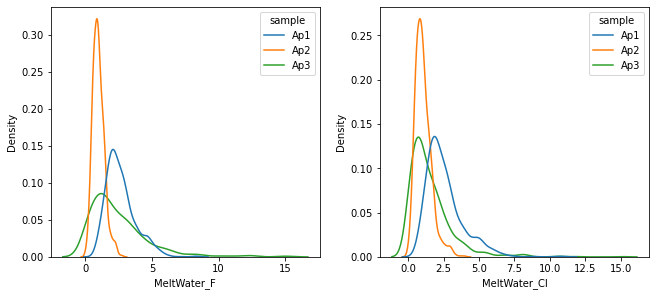

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(9,4), constrained_layout=True)

sns.kdeplot(x = 'MeltWater_F', data=results_mc, hue='sample', ax = axes[0])
sns.kdeplot(x = 'MeltWater_Cl', data=results_mc, hue='sample', ax = axes[1])

plt.show()

1 $\sigma$ errors in results can be calculated by taking half of the range between 84% and 16% of all MCS results. 

melt H<sub>2</sub>O estimated from Cl in the apatite

In [17]:
errors = results_mc.groupby('sample')['MeltWater_Cl'].transform(lambda s: (np.percentile(s, 84)-np.percentile(s, 16))/2).unique()
print(errors)
for ii in list(results_mc['sample']):
    if len(list(results_mc['sample']))<50:
        print(results_mc['sample'][ii],errors[ii])

[1.15167496 0.51788942 1.10956634]


melt H<sub>2</sub>O calculated from F in apatite

In [18]:
errors = results_mc.groupby('sample')['MeltWater_F'].transform(lambda s: (np.percentile(s, 84)-np.percentile(s, 16))/2).unique()
print(errors)
for ii in list(results_mc['sample']):
    if len(list(results_mc['sample']))<50:
        print(results_mc['sample'][ii],errors[ii])

[1.03476596 0.41635992 1.75392207]
